In [11]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import *
from models.nerf import *

import metrics

from datasets import dataset_dict
from datasets.llff import *

torch.backends.cudnn.benchmark = True

img_wh = (200, 200)

# dataset = dataset_dict['llff'] \
#           ('/home/ubuntu/data/nerf_example_data/my/silica4/', 'test_train', spheric_poses=True,
#            img_wh=img_wh)

dataset = dataset_dict['blender'] \
          ('./data/nerf_synthetic/hand_grasp/', 'test',
           img_wh=img_wh)

In [12]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

# ckpt_path = './ckpts/hand_flat/epoch=6.ckpt'
# ckpt_path = './ckpts/hand_yellow/epoch=4.ckpt'
# ckpt_path = './ckpts/hand_flat_4/epoch=7.ckpt'
ckpt_path = './ckpts/hand_flat_same/epoch=7.ckpt'
# ckpt_path = './ckpts/trans_lego/epoch=2.ckpt'
# ckpt_path = 'ckpts/fern/epoch=29.ckpt'
# ckpt_path = 'ckpts/silica3_3/epoch=29.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [13]:
from models.reandering_trans import render_rays_trans
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def f(rays, poses = None):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        poses=None)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

@torch.no_grad()
def f_trans(rays, poses = None, mano_layer = None):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays_trans(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        poses=poses,
                        mano_layer=mano_layer)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [7]:
path = './'
def toObj(vertices, faces, filename='hand.obj', normalize=True):
    if normalize:
        min_x = min(vertices[:, 0])
        max_x = max(vertices[:, 0])
        min_y = min(vertices[:, 1])
        max_y = max(vertices[:, 1])
        min_z = min(vertices[:, 2])
        max_z = max(vertices[:, 2])

        scale = max(max_x - min_x, max_y - min_y, max_z - min_z)

        vertices[:, 0] = (vertices[:, 0] - min_x) * 2 / scale - 1.
        vertices[:, 1] = (vertices[:, 1] - min_y) * 2 / scale - 1.
        vertices[:, 2] = (vertices[:, 2] - min_z) * 2 / scale - 1.

    with open(path + filename, 'w') as f:
        for v in vertices:
            f.write('v %f %f %f\n' % (v[0], v[1], v[2]))

        for face in faces:
            f.write('f %d %d %d\n' % (face[0] + 1, face[1] + 1, face[2] + 1))

In [14]:
from mano.manolayer import ManoLayer

sample = dataset[0]
rays = sample['rays'].cuda()

ncomps = 45
# poses = torch.zeros(1, ncomps + 3, dtype=torch.float32, requires_grad=True)
# poses = torch.ones(1, ncomps + 3, dtype=torch.float32, requires_grad=True)
# poses.data[0][11] = -1.5
# poses.data[0][20] = 1.5
# poses.data[0][29] = 1.
# poses = torch.tensor([0, 0, 0, 0.11167872, 0.04289217, -0.41644184, 0.10881133, -0.06598568, -0.75622001,
#  -0.09639297, -0.09091566, -0.18845929, -0.11809504, 0.05094385, -0.5295845,
#  -0.14369841, 0.0552417, -0.70485714, -0.01918292, -0.09233685, -0.33791352,
#  -0.45703298, -0.19628395, -0.62545753, -0.21465238, -0.06599829, -0.50689421,
#  -0.36972436, -0.06034463, -0.07949023, -0.14186969, -0.08585263, -0.63552826,
#  -0.30334159, -0.05788098, -0.63138921, -0.17612089, -0.13209308, -0.37335458,
#   0.85096428, 0.27692274, -0.09154807, -0.49983944, 0.02655647, 0.05288088, 
#   0.53555915, 0.04596104, -0.27735802], dtype=torch.float32)
# poses = poses.unsqueeze(0)
# poses = -poses

import json

result_dict = {}
with open('./results/grasp_pose_3.json', 'r') as f:
    result_dict = json.load(f)

poses = result_dict['epoch_4']
poses = torch.tensor(poses)
print(poses)

mano_layer = ManoLayer(mano_root='./mano/models', use_pca=False, ncomps=ncomps, flat_hand_mean=True)
shapes = torch.zeros(1, 10)
faces = mano_layer.th_faces
vert_weights = mano_layer.th_weights

# poses = torch.rand(1, ncomps + 3, dtype=torch.float32)
# poses[0, :3] = 0
# poses = torch.pi * poses - torch.pi / 2

t = time.time()
results = f_trans(rays, poses, mano_layer)
torch.cuda.synchronize()
print(time.time()-t)

# verts, _, _ = mano_layer(poses, shapes)
# toObj(verts[0] * 12, faces, filename='hand_random.obj', normalize=False)

tensor([[ 0.0159, -0.0038,  0.0088, -0.0622, -0.0334,  0.5666,  0.2298, -0.0512,
          0.4607,  0.1836,  0.2354,  0.2973, -0.2195, -0.0287,  0.5957,  0.0332,
         -0.1169,  0.7030,  0.6031,  0.3149,  0.1750, -0.2097,  0.3878,  0.7377,
         -0.8786, -0.0580,  0.3600, -0.1645,  0.0030,  0.2707, -0.1831,  0.1110,
          0.7078, -0.3700, -0.0471,  0.2680, -0.2755, -0.0042,  0.2815,  1.2182,
          0.6967,  0.2854, -0.3478,  0.4518,  0.2462,  0.1961,  0.1917,  0.3502]])
36.56519842147827


In [ ]:
verts, _, _ = mano_layer(poses, shapes)
toObj(verts[0] * 12, faces, filename='hand_ones.obj', normalize=False)

PSNR 18.500782012939453


C:\Users\shapi\AppData\Local\Temp\ipykernel_26140\2551200110.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


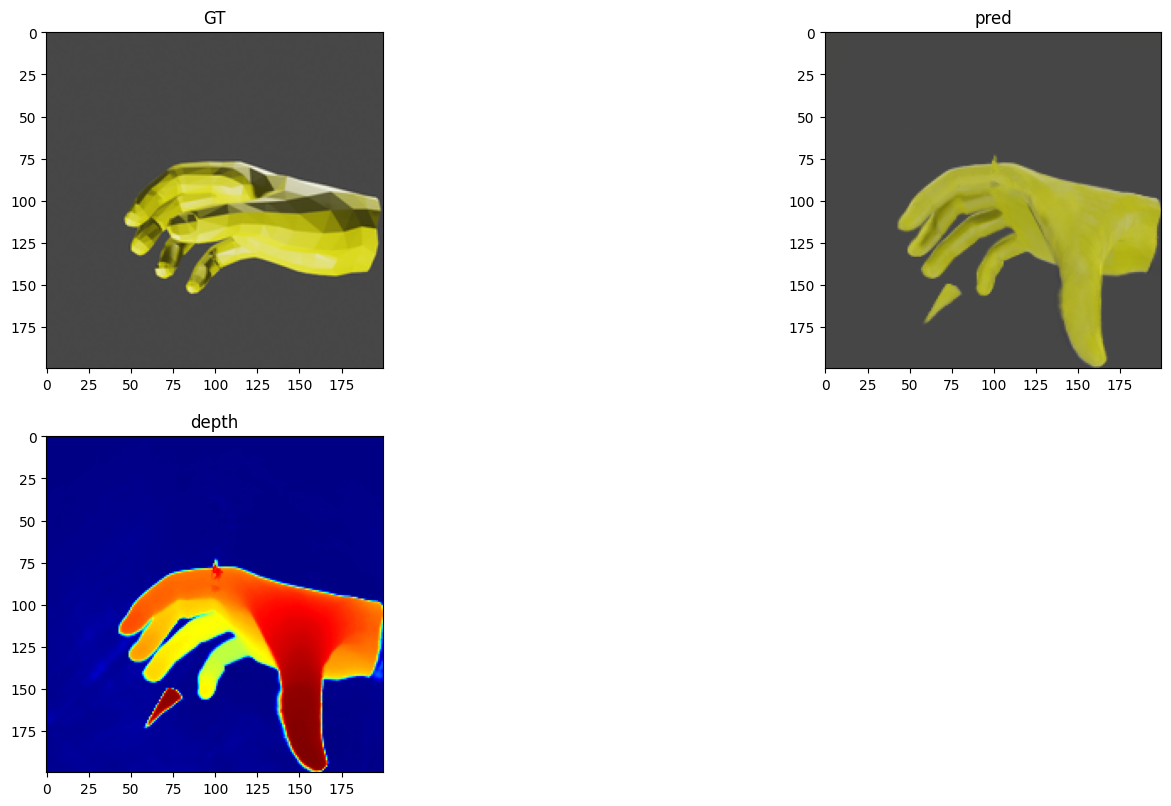

In [15]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])
print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.savefig('./figs/hand_6.png')